In [1]:
import fedhex as fx
from fedhex.pretrain import generation as fxgen
from fedhex.train import SelectiveProgbarLogger
from matplotlib import pyplot as plt
import numpy as np

Welcome to JupyROOT 6.30/02


2024-04-12 12:01:45.541393: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ndim = 2
nx = ny = 10
sigmax = 1 / (nx + 1) / 2
sigmay = 1 / (ny + 1) / 2
sigma = np.array([sigmax, sigmay])

gen = fx.GridGaussGenerator(cov_strat=fxgen.RepeatStrategy(fxgen.DiagCov(ndim=ndim, sigma=sigma)),
                      ngausx=nx,
                      ngausy=ny,
                      seed=0x2024)

In [3]:
nsamp = 1000
samp, lab = gen.generate(nsamp=nsamp)
data, cond = gen.preproc()

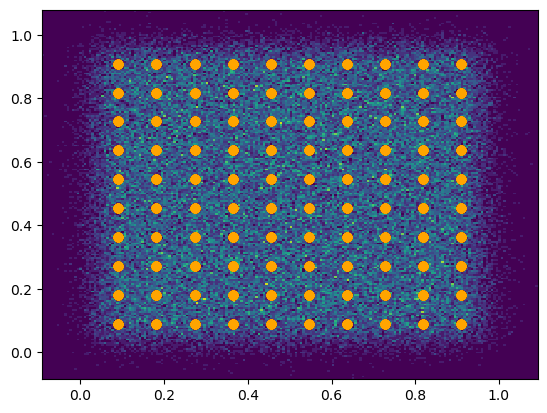

In [4]:
plt.hist2d(samp[:,0], samp[:,1], bins=(200,200))
plt.scatter(lab[:,0], lab[:,1], c="orange")
pass

In [5]:
nmade = 10
ninputs = ncinputs = ndim
hidden_layers = [128]
batch_size = 1024
end_epoch = 200

callbacks = []
log_freq = 10
callbacks.append(SelectiveProgbarLogger(1, epoch_interval=log_freq, epoch_end=end_epoch))

model = fx.MADEManager(nmade=nmade,
               ninputs=ninputs,
               ncinputs=ncinputs,
               hidden_layers=hidden_layers,
               activation="relu")
model.compile_model()
model.train_model(data,
                  cond,
                  batch_size=batch_size,
                  end_epoch=end_epoch)

12:01:55.92 <I> [Training begins]
12:11:09.95 <I> [Training ends]
0:09:14.03 <I> [Time elapsed]


In [20]:
ngen = 10000
newlab = np.repeat([[0.135, 0.135]], ngen, axis=0)
newsamp = model.eval_model(newlab, gen)

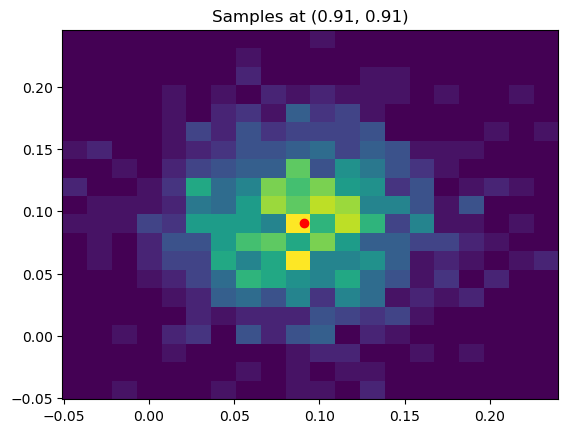

In [19]:
plt.hist2d(samp[0:nsamp,0], samp[0:nsamp,1], bins=(20,20))
plt.scatter(lab[0,0], lab[1,0], c="red")
plt.title("Samples at (0.91, 0.91)")
pass

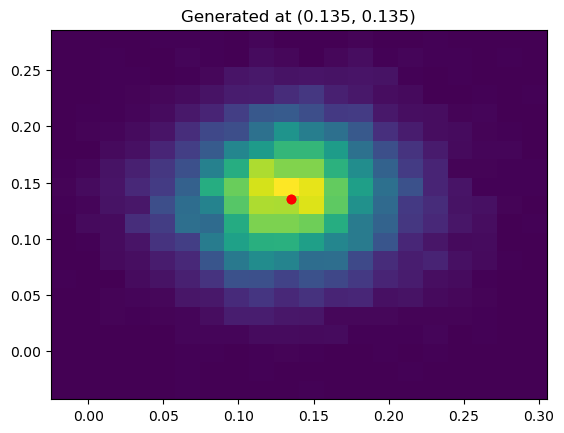

In [21]:
plt.hist2d(newsamp[:,0], newsamp[:,1], bins=(20,20))
plt.scatter(newlab[0], newlab[1], c="red")
plt.title("Generated at (0.135, 0.135)")
pass